In [25]:
import pandas as pd
import numpy as np
import talib as ta

import seaborn as sns
import matplotlib.pyplot as plt


PATH_READ = 'result_ET_1min_Binary.csv'


df = pd.read_csv(PATH_READ)

# df = df[['Target_Class_Avg_1min', 'prediction_label']]

print(df.columns)

Index(['Timestamp', 'tta_BOP',
       'tta_STOCHRSI_timeperiod_6_fastk_period_5_fastd_period_8_0',
       'tta_STOCHRSI_timeperiod_6_fastk_period_5_fastd_period_8_1',
       'tta_TRANGE', 'tta_CDLBELTHOLD', 'tta_CDLCLOSINGMARUBOZU',
       'tta_ULTOSC_timeperiod1_20_timeperiod2_5_timeperiod3_34',
       'tta_MINUS_DM_timeperiod_6', 'tta_ADOSC_fastperiod_14_slowperiod_9',
       'tta_DX_timeperiod_26', 'tta_HT_PHASOR_0', 'tta_HT_PHASOR_1',
       'tta_MFI_timeperiod_36',
       'tta_SAREXT_accelerationlong_28_accelerationshort_26',
       'tta_CDLENGULFING', 'tta_T3_timeperiod_38', 'tta_HT_TRENDMODE',
       'tta_HT_DCPERIOD', 'tta_CDLSHORTLINE', 'tta_HT_DCPHASE',
       'tta_CDL3WHITESOLDIERS', 'tta_CDLMORNINGDOJISTAR', 'tta_CDLTRISTAR',
       'tta_CDLHIKKAKE', 'tta_CDLLONGLEGGEDDOJI', 'tta_HT_SINE_0',
       'tta_HT_SINE_1', 'tta_CDLUNIQUE3RIVER', 'tta_CDL3LINESTRIKE',
       'tta_CDLSTICKSANDWICH', 'tta_CDL3OUTSIDE', 'tta_CDLSPINNINGTOP',
       'tta_CDLLADDERBOTTOM', 'tta_CDLEVENIN

In [96]:
np.power(1.003, 250) - 1

1.1146244779758576

In [26]:
min_value = df['prediction_label'].min()
max_value = df['prediction_label'].max()

print('Predict min: ' + str(min_value))
print('Predict max: ' + str(max_value))

Predict min: -0.0048295994180625
Predict max: 0.0168004775216104


In [27]:
def quantiles(df, num_interval):
    df_sorted = df.sort_values(by='prediction_label')
   
    quantile_markers = pd.qcut(df_sorted['prediction_label'], q=num_interval, labels=False)

# Add the quantile markers as a new column to the DataFrame
    df_sorted['Interval_Marker'] = quantile_markers

    return df_sorted

In [28]:
df_sorted = quantiles(df, 10)


In [29]:
def quant_analysis_list(df, num_interval, target):
    results = []

    for i in range(num_interval):
        selected_rows = df[df['Interval_Marker'] == i]

        acc = (selected_rows[target] * selected_rows['prediction_label'] > 0).mean() * 100
        p_corr = selected_rows[target].corr(selected_rows['prediction_label'])
        s_corr = selected_rows[target].corr(selected_rows['prediction_label'], method='spearman')
        true_mean = selected_rows[target].mean()
        pred_mean = selected_rows[target].mean()

        results.append([i, acc, p_corr, s_corr, true_mean, pred_mean])

    # Create the summary DataFrame
    columns = ['Interval', 'Percent in the Same Direction', 'Correlation Pearson', 'Correlation Spearman', 'True Mean', 'Predicted Mean']
    summary_df = pd.DataFrame(results, columns=columns)

    summary_df.index = summary_df['Interval']
    summary_df.drop(columns='Interval', inplace=True)

    return summary_df

In [75]:
def see_interval(df, interval, target):
    plt.figure(figsize=(10, 5))

    interval_counts = []
    interval_labels = [] 

    for index in interval:
        selected_rows = df[df['Interval_Marker'] == index]

        selected_rows = selected_rows.reset_index()
        text = 'Interval ' + str(index)
        sns.lineplot(data=selected_rows[target], label= text, alpha=0.5)

        # sns.histplot(data=selected_rows[target], kde=True, label = text)
       
    plt.show()

In [76]:
def count_interval(df, interval, target, truthValues):
    plt.figure(figsize=(10, 5))

    interval_counts = []
    interval_labels = [] 

    for index in interval:
        selected_rows = df[(df['Interval_Marker'] == index) & (df[target].isin(truthValues))]

        selected_rows = selected_rows.reset_index()
        text = 'Interval ' + str(index)
        
        count = selected_rows[target].count()
        interval_counts.append(count)
        interval_labels.append('Interval ' + str(index))

    sns.barplot(x=interval_labels, y=interval_counts)
    plt.show()

In [47]:
def categorical_pred_distribution(df, interval, target, truthValues, future_minutes):
    # df['Timestamp'] = df.index
    # df.reset_index(drop= True, inplace=True)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df_time_sort = df.sort_values(by='Timestamp')
    

    for interval_index in interval:
        selected_rows = df_time_sort[(df_time_sort['Interval_Marker'] == interval_index) & ((df_time_sort[target].isin(truthValues)))]
        print("Signal appeared " + str(selected_rows.shape[0]) + " Times in interval " + str(interval_index))

        result = []
        for index, row in selected_rows.iterrows():
            future_index = index + future_minutes
    
            if future_index < len(df):
                future_scores = df.loc[future_minutes+1:future_index, 'Target_Avg_1min']
                future_average = future_scores.mean()

                result.append(future_average)

            else:
                print(f"Row {index}: Not enough future rows for average calculation")    
        
        text = 'Interval ' + str(interval_index)
        sns.lineplot(data=result, label= text, alpha=0.5)
    
    plt.title(target)
    plt.show() 

In [39]:
def categorical_pred_FULL(df, target, truthValues, future_minutes):
    # df.reset_index(drop= True, inplace=True)
    # df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
    df_time_sort = df.sort_values(by='Timestamp')
    
    # print(df_time_sort)

    selected_rows = df_time_sort[(df_time_sort[target].isin(truthValues))]
    print("Signal appeared " + str(selected_rows.shape[0]) + " Times in total.")

    result = []
    for index, row in selected_rows.iterrows():
        future_index = index + future_minutes

        if future_index < len(df):
            future_scores = df.loc[future_minutes+1:future_index, 'Target_Avg_1min']
            future_average = future_scores.mean()

            result.append(future_average)

        else:
            print(f"Row {index}: Not enough future rows for average calculation")    

    sns.lineplot(data=result, label= target, alpha=0.5)

    plt.title(target)
    plt.show() 

In [33]:
print(quant_analysis_list(df_sorted, 10, 'Target_Avg_1min'))

          Percent in the Same Direction  Correlation Pearson  \
Interval                                                       
0                             84.259259             0.400407   
1                             76.851852             0.147339   
2                             78.240741            -0.055919   
3                             67.592593             0.130866   
4                             57.870370             0.052281   
5                             52.314815             0.001110   
6                             59.259259             0.138538   
7                             64.351852             0.023466   
8                             70.833333            -0.041907   
9                             74.074074             0.202566   

          Correlation Spearman  True Mean  Predicted Mean  
Interval                                                   
0                     0.249247  -0.001281       -0.001281  
1                     0.191155  -0.000656       -0.

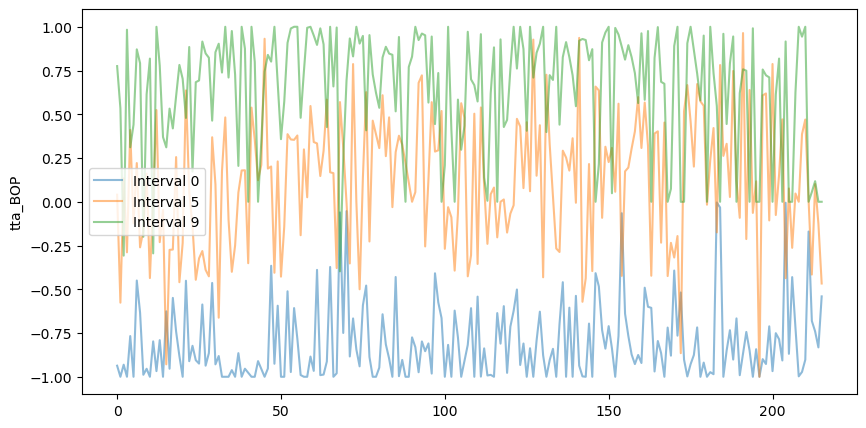

In [84]:
see_interval(df_sorted,[0,5,9], 'tta_BOP')

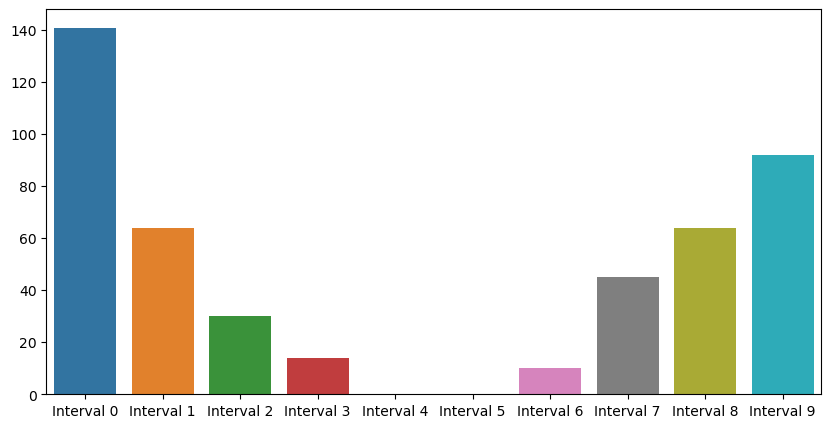

In [79]:
count_interval(df_sorted,np.arange(10),'tta_CDLCLOSINGMARUBOZU', [-100,100])

Signal appeared 123 Times in interval 0
Row 2155: Not enough future rows for average calculation
Signal appeared 71 Times in interval 1
Row 2158: Not enough future rows for average calculation
Signal appeared 63 Times in interval 2
Signal appeared 39 Times in interval 3
Signal appeared 12 Times in interval 4


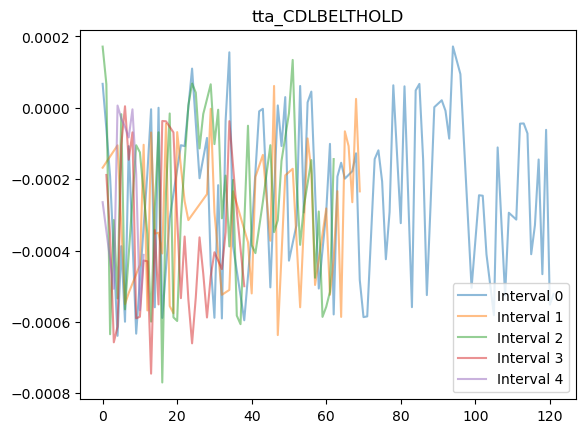

In [66]:
categorical_pred_distribution(df_sorted,[1],'tta_CDLBELTHOLD',[-100,100],5)

Signal appeared 460 Times in total.


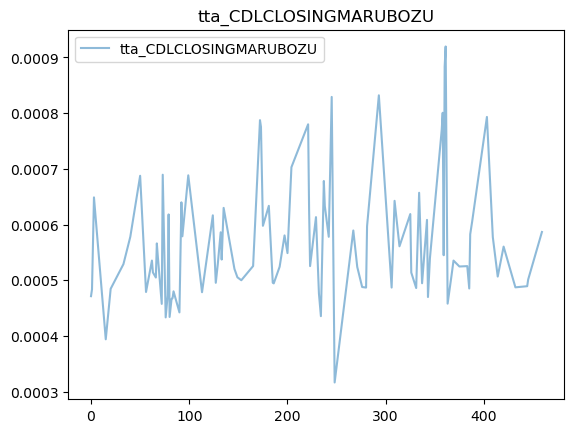

In [52]:
categorical_pred_FULL(df_sorted,'tta_CDLCLOSINGMARUBOZU', [100,-100], 1)

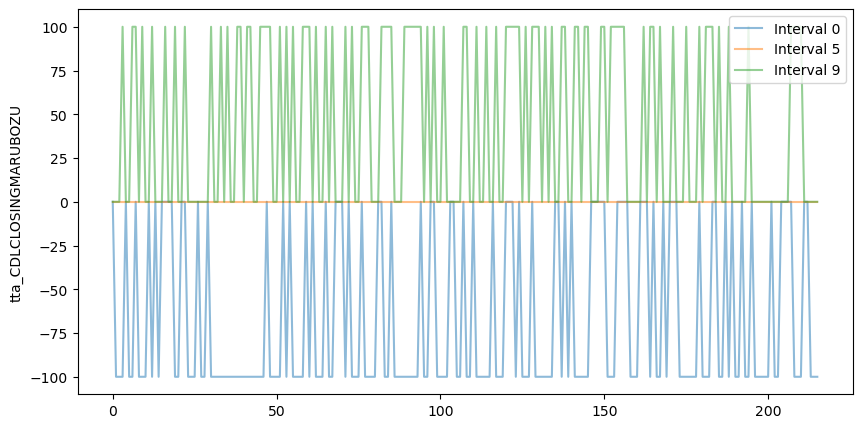

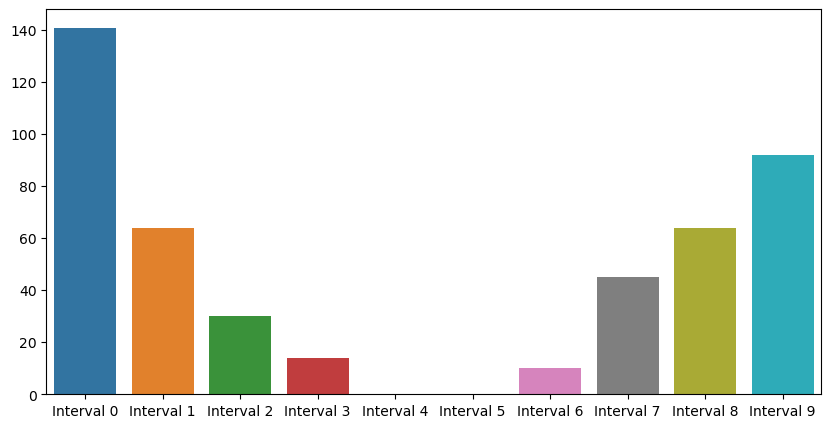

Signal appeared 141 Times in interval 0
Row 2155: Not enough future rows for average calculation


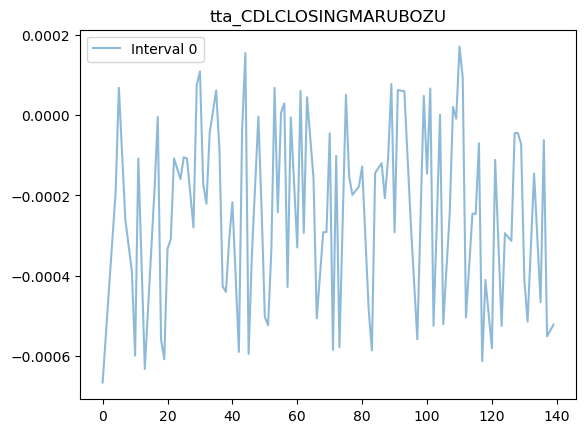

Signal appeared 249 Times in total.


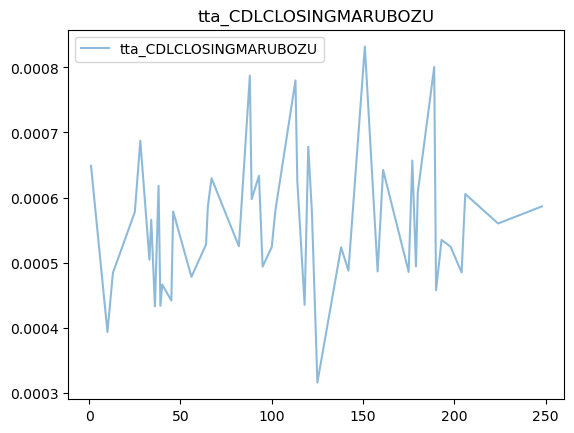

In [92]:
feature = 'tta_CDLCLOSINGMARUBOZU'
see_interval(df_sorted,[0,5,9], feature)
count_interval(df_sorted,np.arange(10),feature, [-100,100])
categorical_pred_distribution(df_sorted,[0],feature,[-100,100],5)
categorical_pred_FULL(df_sorted,feature, [-100], 1)

FI, target corr

正股结果
